# Clustering using PaCMAP
PaCMAP repo: https://github.com/YingfanWang/PaCMAP

Clusters are colored by region

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark(cores=4)
display(spark)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/07 13:19:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/07 13:19:14 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in standalone/kubernetes and LOCAL_DIRS in YARN).


### embeddings

In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Mon Jul  7 13:19:18 EDT 2025


### test embeddings

In [4]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/embeddings"

# Define the path to the train and test parquet files
test_path = f"{data_path}/test_2025/test_2025_embed_logits"

# Read the parquet files into a spark DataFrame
test_df = spark.read.parquet(test_path)

# Show the data
test_df.printSchema()
test_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- output: struct (nullable = true)
 |    |-- cls_token: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |    |-- logits: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |-- sample_id: integer (nullable = true)

+--------------------+--------------------+---------+
|          image_name|              output|sample_id|
+--------------------+--------------------+---------+
|CBN-Pla-A1-201908...|{[0.47354543, 1.5...|        0|
|CBN-Pla-D6-201908...|{[-0.39621377, 1....|        0|
|CBN-PdlC-C5-20140...|{[-0.5331654, 0.2...|        0|
|LISAH-BOU-0-37-20...|{[1.2480925, 0.47...|        0|
|CBN-Pla-E4-201308...|{[0.7065191, 1.70...|        0|
+--------------------+--------------------+---------+
only showing top 5 rows


In [5]:
# count number of rows: should be 2105 for grid=1x1
print(f"Number of rows: {test_df.count()}")

Number of rows: 2105


In [6]:
regions = [
    "2024-CEV3",
    "CBN-can",
    "CBN-PdlC",
    "CBN-Pla",
    "CBN-Pyr",
    "GUARDEN-AMB",
    "GUARDEN-CBNMed",
    "LISAH-BOU",
    "LISAH-BVD",
    "LISAH-JAS",
    "LISAH-PEC",
    "OPTMix",
    "RNNB",
]

len(regions)

13

In [7]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, regexp_extract


def prepare_emb_df(df: DataFrame, embed_col: str = "output.cls_token") -> DataFrame:
    """
    Prepare the DataFrame by renaming the embedding column and selecting relevant columns.
    """
    regex_pattern = "|".join([f"^{region}" for region in regions])
    # add the grouped_regions column using regexp_extract
    test_df_with_regions = df.withColumn(
        "grouped_regions", regexp_extract(col("image_name"), f"({regex_pattern})", 1)
    )

    # check if there are any unmatched regions (empty strings)
    unmatched_count = test_df_with_regions.filter(col("grouped_regions") == "").count()
    print(f"Number of rows with unmatched regions: {unmatched_count}")

    # show the result with the new column
    test_df_with_regions.select("image_name", "grouped_regions", embed_col).show(
        10, truncate=True
    )

    # Count occurrences of each region
    region_counts = (
        test_df_with_regions.groupBy("grouped_regions")
        .count()
        .orderBy(col("count").desc())
    )
    region_counts.show(20)
    return test_df_with_regions


test_df_with_regions = prepare_emb_df(test_df, "output.cls_token")

Number of rows with unmatched regions: 0
+--------------------+---------------+--------------------+
|          image_name|grouped_regions|           cls_token|
+--------------------+---------------+--------------------+
|CBN-Pla-A1-201908...|        CBN-Pla|[0.47354543, 1.55...|
|CBN-Pla-D6-201908...|        CBN-Pla|[-0.39621377, 1.2...|
|CBN-PdlC-C5-20140...|       CBN-PdlC|[-0.5331654, 0.21...|
|LISAH-BOU-0-37-20...|      LISAH-BOU|[1.2480925, 0.478...|
|CBN-Pla-E4-201308...|        CBN-Pla|[0.7065191, 1.709...|
|CBN-PdlC-D6-20150...|       CBN-PdlC|[-0.32394692, 0.4...|
|CBN-PdlC-F2-20170...|       CBN-PdlC|[1.4019761, 1.783...|
|CBN-PdlC-A6-20180...|       CBN-PdlC|[-0.49399343, 1.1...|
|RNNB-3-12-2023051...|           RNNB|[-0.37940657, 0.1...|
|CBN-PdlC-F4-20150...|       CBN-PdlC|[-0.26687536, 1.2...|
+--------------------+---------------+--------------------+
only showing top 10 rows
+---------------+-----+
|grouped_regions|count|
+---------------+-----+
|       CBN-PdlC|  816

In [8]:
test_df_with_regions.count()

2105

In [9]:
import pacmap
import numpy as np
from sklearn.preprocessing import StandardScaler


def get_pandas_embeddings(df: DataFrame, col_name: str):
    # Convert to Pandas DF
    df = df.select([col_name, "grouped_regions"])
    pandas_df = df.select(["cls_token", "grouped_regions"]).toPandas()

    # Extract features and labels
    emb_df = np.stack(pandas_df["cls_token"].values)
    scaled_emb = StandardScaler().fit_transform(emb_df)

    # UMAP reduction
    reducer = pacmap.PaCMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(
        scaled_emb
    )  # NumPy array with shape (n_samples, 2)
    return pandas_df, embedding, scaled_emb

In [10]:
# embeddings
pandas_df, cls_token, cls_scaled_emb = get_pandas_embeddings(
    df=test_df_with_regions, col_name="output.cls_token"
)

In [11]:
print(f"Number rows: {len(pandas_df)}")
pandas_df.head(5)

Number rows: 2105


,cls_token,grouped_regions
0,"[0.47354543, 1.5568701, -1.6330245, -1.3648611...",CBN-Pla
1,"[-0.39621377, 1.2026826, 0.27647698, -0.661421...",CBN-Pla
2,"[-0.5331654, 0.21328913, -1.2809799, 0.1238243...",CBN-PdlC
3,"[1.2480925, 0.4781976, 0.69301766, 0.4653994, ...",LISAH-BOU
4,"[0.7065191, 1.7097996, -1.2477401, 1.3419615, ...",CBN-Pla


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rc("font", size=14)  # Set default font size


def plot_pacmap_clusters(
    pandas_df: pd.DataFrame,
    cls_token: pd.DataFrame,
    col_name: str = "grouped_regions",
    color_by: str = "cluster",  # Options: "cluster" or "kmeans_cluster"
    figsize: tuple = (10, 7),
    dpi: int = 120,
    title=None,
):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    if title:
        fig.suptitle(title, fontsize=20, weight="bold")
    colors = plt.cm.tab10.colors  # Distinct color palette

    pandas_df = pandas_df.copy()
    if color_by == "cluster":
        # Plot top N regions by frequency
        top_regions = pandas_df[col_name].value_counts().nlargest(13).index
        plot_groups = [
            (region, pandas_df[col_name] == region, region) for region in top_regions
        ]
    else:
        # Use cluster column
        cluster_col = "cluster" if "cluster" in pandas_df.columns else "kmeans_cluster"
        pandas_df["kmeans_cluster"] = pandas_df["kmeans_cluster"].add(1)
        unique_clusters = sorted(pandas_df[cluster_col].unique())
        plot_groups = [
            (cid, pandas_df[cluster_col] == cid, f"Cluster {cid}")
            for cid in unique_clusters
        ]

    # Plot loop
    for i, (_, idx, label) in enumerate(plot_groups):
        ax.scatter(
            cls_token[idx, 0],
            cls_token[idx, 1],
            label=label,
            s=20,
            alpha=0.7,
            linewidth=0.5,
            color=colors[i % len(colors)],
        )
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)

    # Remove axis spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    fig.tight_layout(pad=0.8)

    # Add legend
    lgnd = ax.legend(
        ncol=3,
        loc="lower right",
        fontsize=12,
        shadow=True,
    )
    for handle in lgnd.legend_handles:
        handle.set_sizes([60.0])

    plt.show()

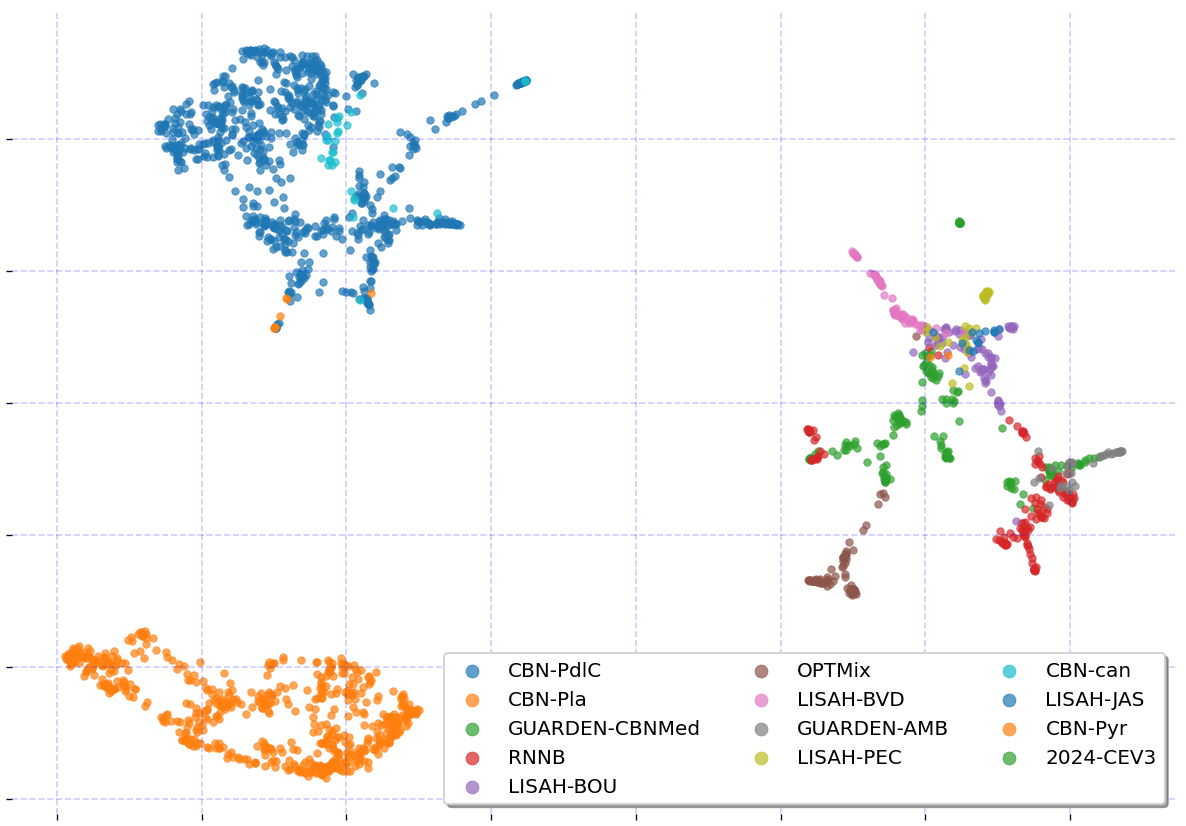

In [13]:
# plot PaCMAP clusters
plot_pacmap_clusters(
    pandas_df,
    cls_token,
    col_name="grouped_regions",
    color_by="cluster",
    figsize=(10, 7),
    dpi=120,
    # title="PaCMAP projection of embeddings colored by region",
)

In [14]:
from sklearn.cluster import KMeans

# run KMeans clustering on the PaCMAP embeddings, get 3 clusters
# for each cluster region --> group by cluster indexes

# apply KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(cls_token)

# add cluster labels to the dataframe
cluster_df = pandas_df.copy()
cluster_df["cluster"] = cluster_labels

# Group by cluster and show regions
cluster_groups = (
    cluster_df.groupby("cluster")["grouped_regions"]
    .apply(list)
    .reset_index(name="regions")
)
cluster_groups.head()

,cluster,regions
0,0,"[LISAH-BOU, RNNB, LISAH-BOU, RNNB, RNNB, RNNB,..."
1,1,"[CBN-PdlC, CBN-PdlC, CBN-PdlC, CBN-PdlC, CBN-P..."
2,2,"[CBN-Pla, CBN-Pla, CBN-Pla, CBN-Pla, CBN-Pla, ..."


In [15]:
def analyze_cluster(cluster_df, cluster_idx):
    """
    Analyze the regions in a specific cluster.

    Args:
        cluster_df: DataFrame containing cluster information
        cluster_idx: The cluster index to analyze (0, 1, or 2)

    Returns:
        Tuple of (filtered_df, regions_list)
    """
    # Filter dataframe for the specified cluster
    filtered_cluster = cluster_df[cluster_df["cluster"] == cluster_idx]

    # Extract unique regions in this cluster
    cluster_regions = filtered_cluster["grouped_regions"].unique().tolist()

    # Show the unique regions
    print(f"Cluster {cluster_idx} contains {len(cluster_regions)} unique regions:")
    print(cluster_regions)

    # Count occurrences of each region in this cluster
    region_counts = filtered_cluster["grouped_regions"].value_counts().reset_index()
    region_counts.columns = ["Region", "Count"]
    display(region_counts)

    return filtered_cluster, cluster_regions

In [16]:
cluster0_df, cluster0_regions = analyze_cluster(cluster_df, 0)
cluster1_df, cluster1_regions = analyze_cluster(cluster_df, 1)
cluster2_df, cluster2_regions = analyze_cluster(cluster_df, 2)

Cluster 0 contains 10 unique regions:
['LISAH-BOU', 'RNNB', 'OPTMix', 'GUARDEN-CBNMed', 'LISAH-BVD', 'LISAH-JAS', 'LISAH-PEC', 'GUARDEN-AMB', 'CBN-Pyr', '2024-CEV3']


,Region,Count
0,GUARDEN-CBNMed,165
1,RNNB,141
2,LISAH-BOU,82
3,OPTMix,78
4,LISAH-BVD,76
5,GUARDEN-AMB,36
6,LISAH-PEC,35
7,LISAH-JAS,15
8,CBN-Pyr,2
9,2024-CEV3,1


Cluster 1 contains 3 unique regions:
['CBN-PdlC', 'CBN-can', 'CBN-Pla']


,Region,Count
0,CBN-PdlC,815
1,CBN-can,30
2,CBN-Pla,8


Cluster 2 contains 2 unique regions:
['CBN-Pla', 'CBN-PdlC']


,Region,Count
0,CBN-Pla,620
1,CBN-PdlC,1


In [17]:
cluster0_df.head(5)

,cls_token,grouped_regions,cluster
3,"[1.2480925, 0.4781976, 0.69301766, 0.4653994, ...",LISAH-BOU,0
8,"[-0.37940657, 0.11167338, 0.65568197, 2.197065...",RNNB,0
10,"[0.9018275, 0.80048716, 0.26462603, 1.3513545,...",LISAH-BOU,0
14,"[1.3867496, 0.1623872, 0.55915254, 2.3217552, ...",RNNB,0
17,"[-1.5199383, 0.42953554, 0.9965646, 2.3927414,...",RNNB,0


In [18]:
def region_counts(cluster_df):
    # count occurrences of each region in this cluster
    region_counts = cluster_df["grouped_regions"].value_counts().reset_index()
    region_counts.columns = ["Region", "Count"]
    return region_counts


cluster0_counts = region_counts(cluster0_df)
cluster1_counts = region_counts(cluster1_df)
cluster2_counts = region_counts(cluster2_df)

clusters = [cluster0_counts, cluster1_counts, cluster2_counts]

# Create a mapping of region to cluster counts
cluster_counts = {}
for cluster_idx, cluster_df in enumerate(clusters):
    for _, row in cluster_df.iterrows():
        region = row["Region"]
        count = row["Count"]
        if region not in cluster_counts:
            cluster_counts[region] = {}
        cluster_counts[region][cluster_idx] = count

# Fill in zeros for missing entries
for region in cluster_counts:
    for cluster_idx in range(len(clusters)):
        if cluster_idx not in cluster_counts[region]:
            cluster_counts[region][cluster_idx] = 0

# determine the dominant cluster for each region
dominant_cluster = {}
for region, counts in cluster_counts.items():
    dominant_cluster[region] = max(counts.items(), key=lambda x: x[1])[0]

dominant_cluster

{'GUARDEN-CBNMed': 0,
 'RNNB': 0,
 'LISAH-BOU': 0,
 'OPTMix': 0,
 'LISAH-BVD': 0,
 'GUARDEN-AMB': 0,
 'LISAH-PEC': 0,
 'LISAH-JAS': 0,
 'CBN-Pyr': 0,
 '2024-CEV3': 0,
 'CBN-PdlC': 1,
 'CBN-can': 1,
 'CBN-Pla': 2}

In [19]:
# create a column kmeans_cluster in the pandas_df based on the dominant cluster
def map_dominant_cluster(pandas_df, dominant_cluster):
    # Map the dominant cluster to the DataFrame
    pandas_df["kmeans_cluster"] = pandas_df["grouped_regions"].map(dominant_cluster)
    return pandas_df


pandas_cluster_df = pandas_df.copy()
pandas_cluster_df = map_dominant_cluster(pandas_cluster_df, dominant_cluster)
pandas_cluster_df.head(5)

,cls_token,grouped_regions,kmeans_cluster
0,"[0.47354543, 1.5568701, -1.6330245, -1.3648611...",CBN-Pla,2
1,"[-0.39621377, 1.2026826, 0.27647698, -0.661421...",CBN-Pla,2
2,"[-0.5331654, 0.21328913, -1.2809799, 0.1238243...",CBN-PdlC,1
3,"[1.2480925, 0.4781976, 0.69301766, 0.4653994, ...",LISAH-BOU,0
4,"[0.7065191, 1.7097996, -1.2477401, 1.3419615, ...",CBN-Pla,2


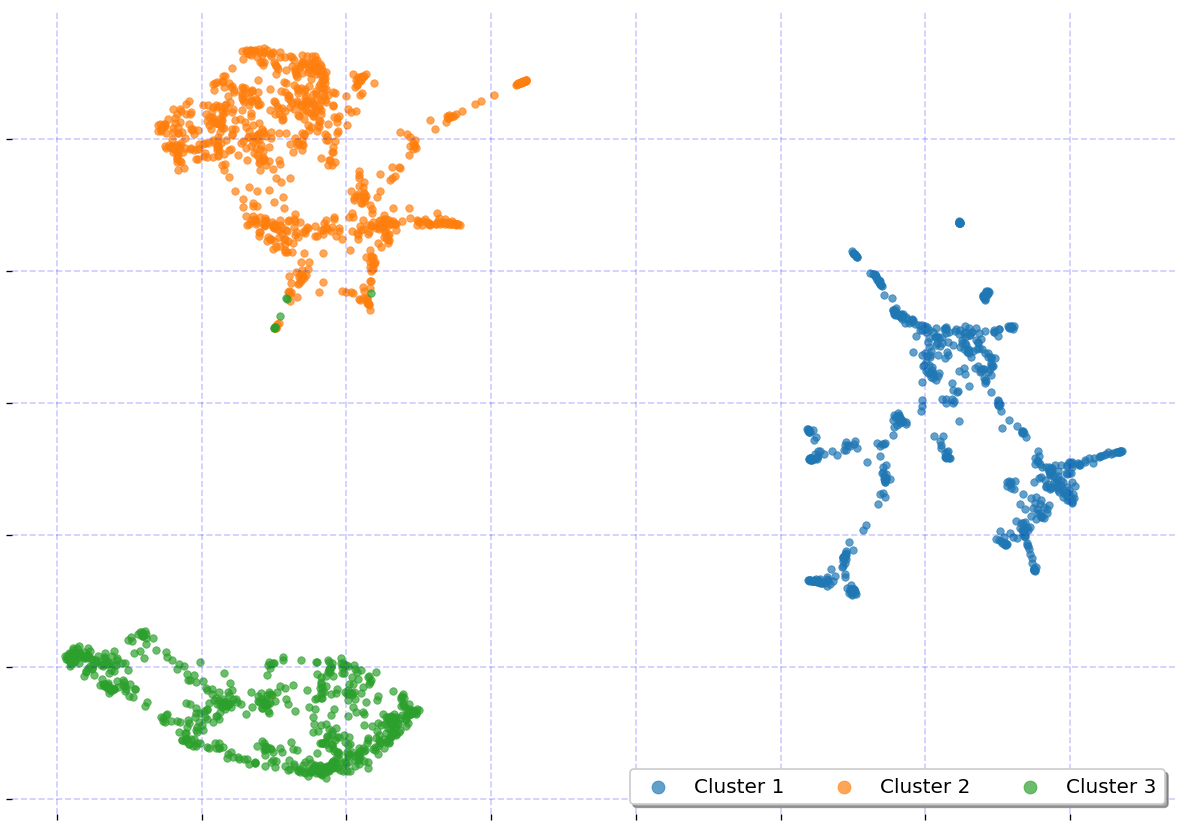

In [20]:
# plot PaCMAP clusters
plot_pacmap_clusters(
    pandas_cluster_df,
    cls_token,
    col_name="grouped_regions",
    color_by="kmeans_cluster",
    figsize=(10, 7),
    dpi=120,
    # title="PaCMAP projection of embeddings colored by KMeans cluster",
)

### pickle the model

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


class PaCMAPTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, random_state=42):
        self.n_components = n_components
        self.random_state = random_state
        self.reducer = None
        self.embedding_ = None

    def fit(self, X, y=None):
        self.reducer = pacmap.PaCMAP(
            n_components=self.n_components, random_state=self.random_state
        )
        self.embedding_ = self.reducer.fit_transform(X)
        return self

    def transform(self, X):
        # just return the already-computed embedding
        return self.embedding_


clustering_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pacmap", PaCMAPTransformer(n_components=2, random_state=42)),
        ("cluster", KMeans(n_clusters=5, random_state=42)),
    ]
)

In [22]:
# Convert to Pandas DF
col_name = "output.cls_token"
df = test_df_with_regions.select([col_name, "grouped_regions"])
pandas_df = df.select(["cls_token", "grouped_regions"]).toPandas()
cls_token = np.stack(pandas_df["cls_token"].values)

# Fit on your embedding data
clustering_pipeline.fit(cls_token)  # Using your scaled embeddings

# To get cluster labels
cluster_labels = clustering_pipeline.predict(cls_token)
print(f"cluster labels shape: {cluster_labels.shape}")
cluster_labels[:10]

cluster labels shape: (2105,)


array([2, 2, 1, 4, 2, 3, 1, 3, 0, 1], dtype=int32)

In [23]:
import os
import pickle
from pathlib import Path

# Define where to save the model
model_dir = (
    Path(os.path.expanduser("~")) / "p-dsgt_clef2025-0/shared/plantclef/models/pacmap"
)
model_dir.mkdir(parents=True, exist_ok=True)

# Fit the model if you haven't already
clustering_pipeline.fit(cls_token)

# Save the fitted pipeline to a file
pipeline_filename = model_dir / "plant_clustering_pipeline.pkl"
with open(pipeline_filename, "wb") as file:
    pickle.dump(clustering_pipeline, file)

print(f"Saved clustering pipeline to {pipeline_filename}")

Saved clustering pipeline to /storage/home/hcoda1/9/mgustineli3/p-dsgt_clef2025-0/shared/plantclef/models/pacmap/plant_clustering_pipeline.pkl


In [24]:
# To load the model later
with open(pipeline_filename, "rb") as file:
    loaded_pipeline = pickle.load(file)

# Use the loaded pipeline to predict on new data
new_cluster_labels = loaded_pipeline.predict(
    cls_token
)  # replace cls_token with new data
new_cluster_labels[:10]

array([2, 2, 1, 4, 2, 3, 1, 3, 0, 1], dtype=int32)

### create CSV dataframe of dominant clusters 

In [25]:
# map dominant cluster to the test_df_with_regions
def map_dominant_cluster(test_df, dominant_cluster):
    pandas_df = test_df.select("image_name", "grouped_regions").toPandas()
    pandas_df = pandas_df.copy()

    # map the dominant cluster to the DataFrame
    pandas_df["kmeans_cluster"] = pandas_df["grouped_regions"].map(dominant_cluster)

    # select only the required columns
    pandas_df = pandas_df[["image_name", "kmeans_cluster"]]
    return pandas_df


test_cluster_df = map_dominant_cluster(test_df_with_regions, dominant_cluster)
test_cluster_df.head(5)

,image_name,kmeans_cluster
0,CBN-Pla-A1-20190814.jpg,2
1,CBN-Pla-D6-20190814.jpg,2
2,CBN-PdlC-C5-20140901.jpg,1
3,LISAH-BOU-0-37-20230512.jpg,0
4,CBN-Pla-E4-20130808.jpg,2


In [26]:
# write pandas to PACE as CSV
def write_to_pace(df, path):
    df.to_csv(path, index=False)
    print(f"DataFrame written to {path}")


file_name = "test_2025_dominant_clusters.csv"
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/clustering/{file_name}"
write_to_pace(test_cluster_df, data_path)

DataFrame written to /storage/home/hcoda1/9/mgustineli3/p-dsgt_clef2025-0/shared/plantclef/data/clustering/test_2025_dominant_clusters.csv


In [27]:
test_cluster_df.shape

(2105, 2)